In [7]:
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime

In [8]:
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt'
df = pd.read_csv(url, header = 0, sep=',')
df.columns = map(str.lower, df.columns) # - make headers lowercase
df.columns = df.columns.str.strip().str.lower()

In [9]:
df['ttime'] = pd.to_datetime(df['time'])
df['tdate'] = pd.to_datetime(df['date'])
df['datetime'] = df.apply (lambda x: datetime.datetime (x['tdate'].year, x['tdate'].month, x['tdate'].day,
                                                       x['ttime'].hour), axis=1)
df.drop (['ttime','tdate'], inplace=True, axis=1)
df['exit_increments'] = df['exits']
df['entry_increments'] = df['entries']
df['previous_entry_number'] = df['entries']
df['time_block'] = df['entries']
df['previous_datetime'] = df['datetime']

# -- add day of week column value
df['weekday'] = df['datetime'].dt.weekday_name



In [11]:
#This creates the dataframe that will be used to store entries for a given station/control area pair for hours
#of the day
tuple1 = ('59 ST', 'A002', 1)

#Convert a tuple into a string for indexing purposes. This is an unfortunate kludge that was necessary due to having
#trouble using a tuple as an index
def string_from_tuple (tup):
    return tup[0]+','+tup[1]+','+str(tup[2])

summary_data = pd.DataFrame(
    data={'c_a_station_time_block': [tuple1],
          'c_a_station': [('59 ST', 'A002')],
          'time_block': [1],
          'entries': [0]},
    index=[string_from_tuple (tuple1)],
    columns=['c_a_station_time_block', 'c_a_station', 'time_block', 'entries'])

#Tabulate the number of entries over a particular four hour block at a particular station/control area pair
def tabulate_entries (ix, data_frame):
    station = data_frame.at [ix, 'station']
    control_area = data_frame.at [ix, 'c/a']
    time_block = data_frame.at [ix, 'time_block']
    entries = data_frame.at [ix, 'entry_increments']
    c_a_station = (station, control_area)
    c_a_station_time_block = (station, control_area, time_block)
    summary_index = string_from_tuple (c_a_station_time_block)
    try:
        existing_entries = summary_data.at [summary_index, 'entries']
        summary_data.at [summary_index, 'entries'] = entries + existing_entries
    except KeyError:
        summary_data.loc [summary_index] = [c_a_station_time_block, c_a_station, time_block, entries]

#Converts a datetime to an integer code representing the four hour block in the week, because
#MTA generally uses four hour intervals. 12am-2am Saturday = 0, 2am-6am Saturday = 1, and so on up to
#6pm-10pm Friday = 41, 10pm-midnight Friday = 42
def convert_datetime_to_four_hour_block (dt):
    day_of_week = dt.weekday()
    day_of_week += 2
    if day_of_week >= 7:
        day_of_week -= 7
    hour = round((dt.hour+.01)/4)
    result = int((6*day_of_week) + hour)
    return result

def max_minus_min_exits (x):
    first_iteration = True
    previous_exits = 0
    for index, row in x.iteritems():
        if first_iteration:
            first_iteration = False
            previous_exits = row
            df.at [index, 'exit_increments'] = -1
        else:
            df.at [index, 'exit_increments'] = row - previous_exits
            previous_exits = row
    result = x.max()-x.min()
    return result
    
def max_minus_min_entries (x):
    first_iteration = True
    previous_entries = 0
    previous_datetime = datetime.datetime (1980,1,1)
    for index, row in x.iteritems():
        if first_iteration:
            first_iteration = False
            previous_entries = row
            df.at [index, 'previous_datetime'] = previous_datetime
            previous_datetime = df.at [index, 'datetime']
            df.at [index, 'entry_increments'] = -1
            df.at [index, 'previous_entry_number'] = -1
            df.at [index, 'time_block'] = -1
        else:
            df.at [index, 'previous_datetime'] = previous_datetime
            previous_datetime = df.at [index, 'datetime']
            entry_count = row - previous_entries
            df.at [index, 'entry_increments'] = entry_count
            df.at [index, 'previous_entry_number'] = previous_entries
            df.at [index, 'time_block'] = convert_datetime_to_four_hour_block (previous_datetime)
            if (entry_count >0) and (entry_count < 5000):
                tabulate_entries (index, df)
            previous_entries = row
    result = x.max()-x.min()
    return result
    
dfgb_exit_group = df.groupby (['station', 'c/a', 'unit', 'scp']) ['exits'].apply (max_minus_min_exits)
dfgb_entry_group = df.groupby (['station', 'c/a', 'unit', 'scp']) ['entries'].apply (max_minus_min_entries)
dfgb2 = dfgb_exit_group.groupby ('station')
dfgb3 = dfgb2.apply (lambda x:x.sum())
dfgb4 = dfgb3.sort_values (0, False)
#print (dfgb4)
#print (dfgb4.sum())
#print(len(dfgb4))
dfgb4.tail(360).sum()
dfgb=dfgb_exit_group.sort_values (0, False)
print (dfgb.sum())
print (len(dfgb))
print (dfgb)
dfgb.tail(4875).sum()

1935980727
4876
station          c/a    unit  scp     
167 ST           N207   R104  00-00-00    1821597417
59 ST            C021   R212  00-00-03      14611973
42 ST-PORT AUTH  N062A  R010  00-06-01       4576563
23 ST            N077   R111  02-06-02       3130109
CHRISTOPHER ST   PTH09  R548  00-00-02       2928014
EXCHANGE PLACE   PTH05  R543  00-00-07       2846786
THIRTY ST        PTH13  R541  00-04-05       2844815
PAVONIA/NEWPORT  PTH06  R546  00-00-05       2611206
THIRTY THIRD ST  PTH17  R541  01-00-05       2221453
TWENTY THIRD ST  PTH12  R542  00-04-00       2111768
PAVONIA/NEWPORT  PTH06  R546  00-00-06       2012831
EXCHANGE PLACE   PTH05  R543  00-00-06       1911541
PAVONIA/NEWPORT  PTH06  R546  00-00-08       1878563
174-175 STS      N212   R253  01-00-01       1789843
THIRTY THIRD ST  PTH17  R541  01-00-02       1783205
                              01-00-09       1591311
EXCHANGE PLACE   PTH05  R543  00-00-04       1349652
LACKAWANNA       PTH16  R550  01-02-00      

114383310

In [85]:
sort_mask = (df['entry_increments'] > -1) & (df['exit_increments'] > -1
                                             ) &(df['entry_increments'] < 5000
                                                ) & (df['exit_increments'] < 5000)


df = df[sort_mask]
df.head()

# - this is a deep div into the hourly incrementation per terminal

# entry increments -- the number of entries in the current 4 hour period 
#-----at the beginning at previous datetime and ending at datetime
# exit increments -- the number of exits in the 4 hour period starting at
# -----the beginnning of the previous datetime and ending at datetime
# time_block -- represents what 4 hour period the datetime is in during 
# ---- period week. number of 4 hour periods that 
# -----have elapsed since saturday midnight
# 


,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,exit_increments,entry_increments,previous_entry_number,time_block,previous_datetime,weekday
52136,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/10/2019,20:00:00,REGULAR,1421485,5605831,2019-06-10 20:00:00,4753,85,1421400,17,2019-06-10 16:00:00,Monday
52142,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/11/2019,20:00:00,REGULAR,1423900,5616013,2019-06-11 20:00:00,4465,102,1423798,23,2019-06-11 16:00:00,Tuesday
52150,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/12/2019,20:00:00,REGULAR,1426088,5626830,2019-06-12 20:00:00,4303,97,1425991,29,2019-06-12 16:00:00,Wednesday
159673,R240,R047,00-00-00,GRD CNTRL-42 ST,4567S,IRT,06/13/2019,13:00:00,REGULAR,5315468,13039820,2019-06-13 13:00:00,4264,182,5315286,33,2019-06-13 09:00:00,Thursday
52180,N063A,R011,00-00-01,42 ST-PORT AUTH,ACENQRS1237W,IND,06/10/2019,20:00:00,REGULAR,1280095129,176305697,2019-06-10 20:00:00,4238,139,1280094990,17,2019-06-10 16:00:00,Monday


In [37]:
summary_data.head()

,c_a_station_time_block,c_a_station,time_block,entries
"59 ST,A002,1","(59 ST, A002, 1)","(59 ST, A002)",1,283
"1 AV,H007,11","(1 AV, H007, 11)","(1 AV, H007)",11,2
"1 AV,H007,14","(1 AV, H007, 14)","(1 AV, H007)",14,1493
"1 AV,H007,15","(1 AV, H007, 15)","(1 AV, H007)",15,3282
"1 AV,H007,16","(1 AV, H007, 16)","(1 AV, H007)",16,2616


In [46]:
# - entries by station by day

station_day_groupby = df.groupby(["date", 'station','weekday']
                                )['entry_increments', 'exit_increments'
                                 ].sum().reset_index().sort_values('entry_increments', ascending=False)
station_day_groupby.head()


,date,station,weekday,entry_increments,exit_increments
1950,06/13/2019,34 ST-PENN STA,Thursday,182825,158274
1195,06/11/2019,34 ST-PENN STA,Tuesday,177588,152787
1573,06/12/2019,34 ST-PENN STA,Wednesday,177136,158956
817,06/10/2019,34 ST-PENN STA,Monday,170136,146196
2120,06/13/2019,GRD CNTRL-42 ST,Thursday,167009,142257


In [65]:
# - entries and exits correlatie with time of day
# - entries and exits with weekday
# - which stations have the hightest entries and exits per weekday

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


In [99]:
#

station_groupby = df.groupby(['station', 'time_block']
                                )['entry_increments', 'exit_increments'
                                 ].sum().reset_index()

In [93]:
df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,exit_increments,entry_increments,previous_entry_number,time_block,previous_datetime,weekday
52136,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/10/2019,20:00:00,REGULAR,1421485,5605831,2019-06-10 20:00:00,4753,85,1421400,17,2019-06-10 16:00:00,Monday
52142,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/11/2019,20:00:00,REGULAR,1423900,5616013,2019-06-11 20:00:00,4465,102,1423798,23,2019-06-11 16:00:00,Tuesday
52150,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/12/2019,20:00:00,REGULAR,1426088,5626830,2019-06-12 20:00:00,4303,97,1425991,29,2019-06-12 16:00:00,Wednesday
159673,R240,R047,00-00-00,GRD CNTRL-42 ST,4567S,IRT,06/13/2019,13:00:00,REGULAR,5315468,13039820,2019-06-13 13:00:00,4264,182,5315286,33,2019-06-13 09:00:00,Thursday
52180,N063A,R011,00-00-01,42 ST-PORT AUTH,ACENQRS1237W,IND,06/10/2019,20:00:00,REGULAR,1280095129,176305697,2019-06-10 20:00:00,4238,139,1280094990,17,2019-06-10 16:00:00,Monday


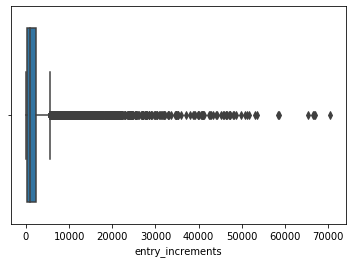

In [95]:
# - box plot to find outliers

sns.boxplot(x=station_groupby['entry_increments'])

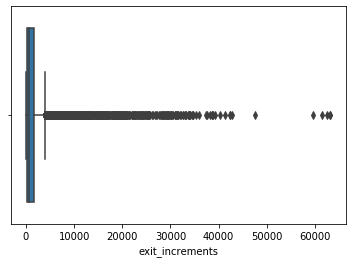

In [96]:
# - box plot to find outliers exits

sns.boxplot(x=station_groupby['exit_increments'])

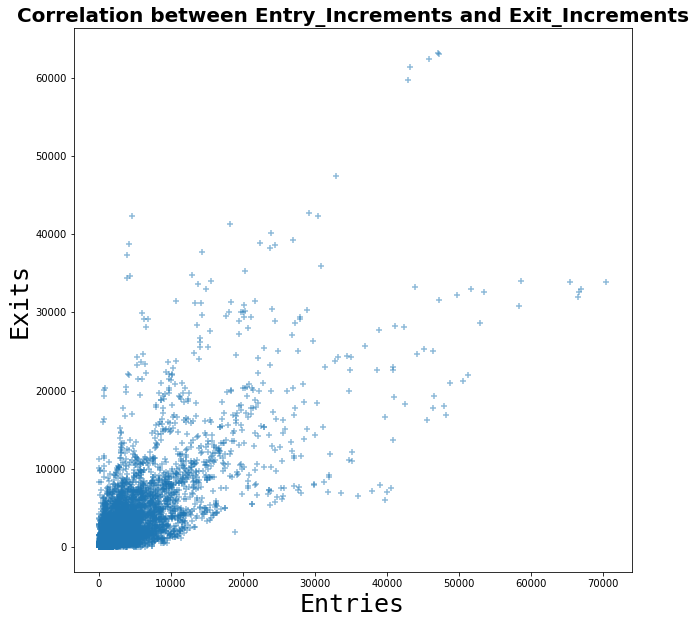

In [97]:
# - entries correlated with exits


# correlations = station_groupby.corr()
plt.figure(figsize=[10,10])
plt.scatter(station_groupby['entry_increments']
            , station_groupby['exit_increments']
            ,marker = '+'
           , alpha = 0.5)
plt.title('Correlation between Entry_Increments and Exit_Increments', fontsize=20, weight = 'bold')
plt.xlabel("Entries", fontsize = '25', family = 'monospace',color='black');
plt.ylabel("Exits", fontsize = '25', family = 'monospace',color='black');


plt.show();



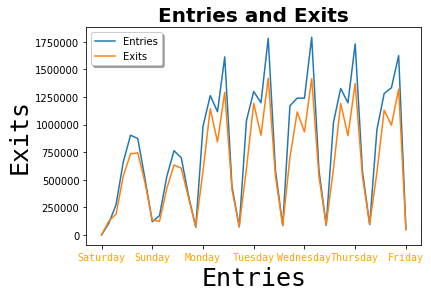

In [117]:
weekday_groupby = df.groupby(['time_block'])['entry_increments','exit_increments'].sum().reset_index()

plt.plot(weekday_groupby['time_block'],weekday_groupby['entry_increments'])
plt.plot(weekday_groupby['time_block'],weekday_groupby['exit_increments'])
plt.title('Entries and Exits', fontsize=20, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='orange')
plt.xlabel("Entries", fontsize = '25', family = 'monospace',color='black');
plt.ylabel("Exits", fontsize = '25', family = 'monospace',color='black');
plt.legend(['Entries','Exits'],shadow = True, loc = 0);


In [150]:
#top 6 control areas
#grid plots of entries and exits by day


# - find top stations over the week
topstations_groupby = df.groupby(['station','time_block'])['entry_increments','exit_increments'].sum().sort_values('time_block',ascending = True).reset_index()
topstations_groupby.head(6)




,station,time_block,entry_increments,exit_increments
0,125 ST,0,4,10
1,TWENTY THIRD ST,0,0,0
2,WOODHAVEN BLVD,0,0,1
3,NORWOOD AV,1,55,123
4,34 ST-PENN STA,1,2180,2059
5,NORWOOD 205 ST,1,134,362


In [151]:
# - create masks for top stations

penn_mask = (topstations_groupby['station'] == '34 ST-PENN STA')
penn_df = topstations_groupby[penn_mask]

grand_mask = (topstations_groupby['station'] == 'GRD CNTRL-42 ST')
grand_df = topstations_groupby[grand_mask]

herald_mask = (topstations_groupby['station'] == '34 ST-HERALD SQ')
herald_df = topstations_groupby[herald_mask]

twentythird_mask = (topstations_groupby['station'] == '23 ST')
twentythird_df = topstations_groupby[twentythird_mask]

union_mask = (topstations_groupby['station'] == '14 ST-UNION SQ')
union_df = topstations_groupby[union_mask]

times_mask = (topstations_groupby['station'] == 'TIMES SQ-42 ST')
times_df = topstations_groupby[times_mask]


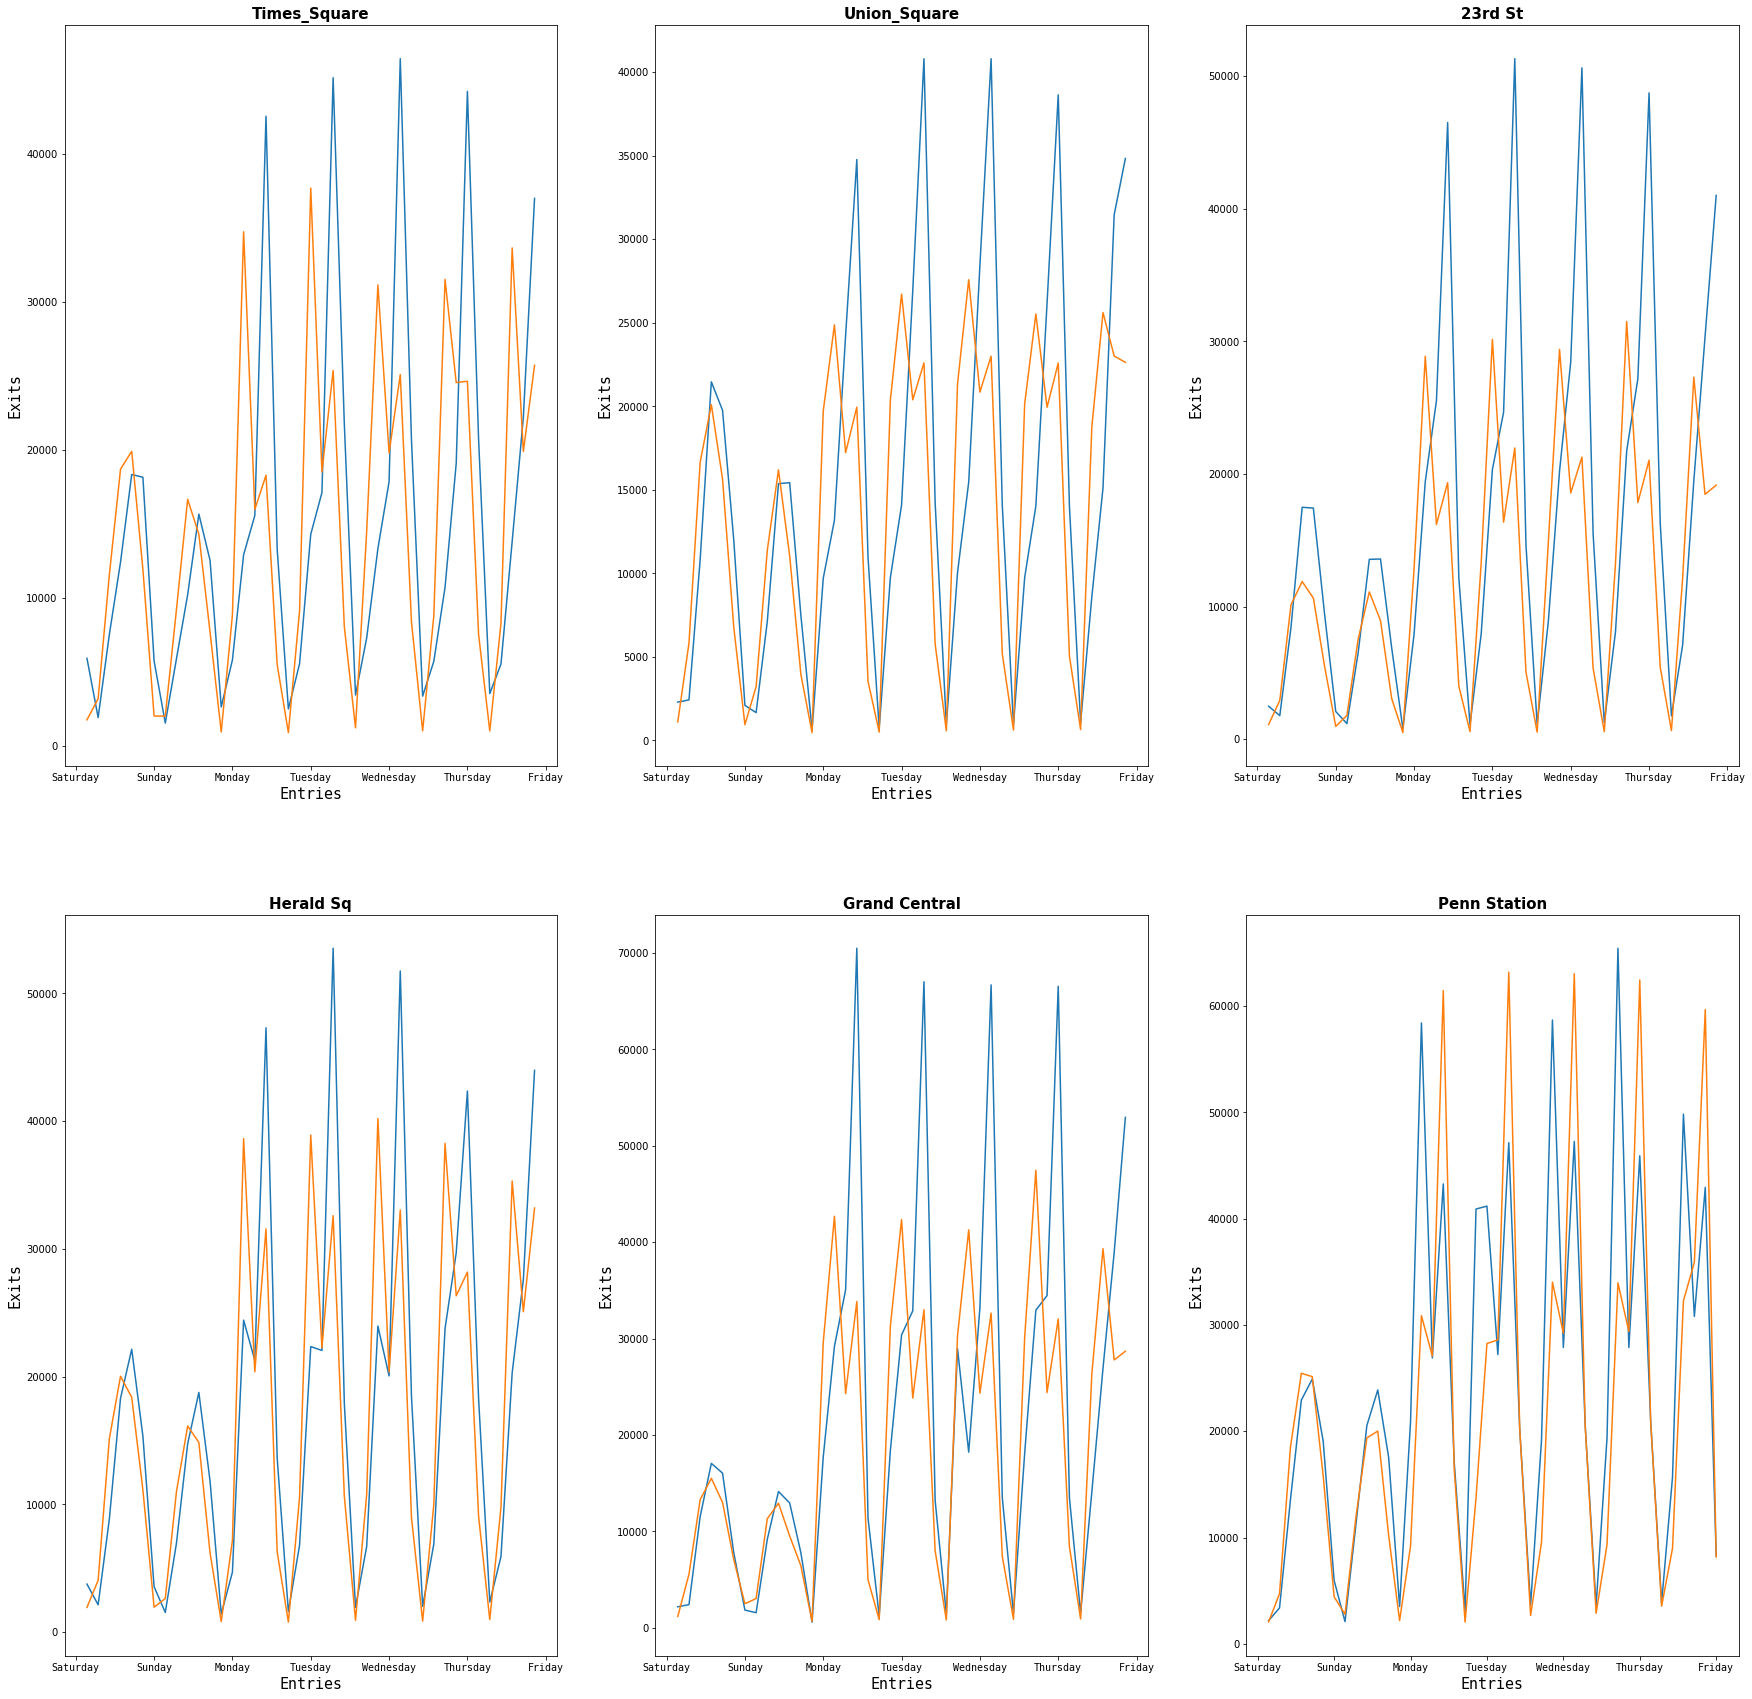

In [161]:
fig.set_figwidth(10)
fig.set_figheight(6)


plt.figure(figsize = [30, 30])

fig.suptitle('Top 6 Performing Stations',fontsize = 16)

plt.subplot(2,3,1)
plt.plot(times_df['time_block'],times_df['entry_increments'])
plt.plot(times_df['time_block'],times_df['exit_increments'])
plt.title('Times_Square', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.xlabel("Entries", fontsize = '15', family = 'monospace',color='black');
plt.ylabel("Exits", fontsize = '15', family = 'monospace',color='black')



plt.subplot(2,3,2)
plt.plot(union_df['time_block'],union_df['entry_increments'])
plt.plot(union_df['time_block'],union_df['exit_increments'])
plt.title('Union_Square', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.xlabel("Entries", fontsize = '15', family = 'monospace',color='black');
plt.ylabel("Exits", fontsize = '15', family = 'monospace',color='black')


plt.subplot(2,3,3)
plt.plot(twentythird_df['time_block'],twentythird_df['entry_increments'])
plt.plot(twentythird_df['time_block'],twentythird_df['exit_increments'])
plt.title('23rd St', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.xlabel("Entries", fontsize = '15', family = 'monospace',color='black');
plt.ylabel("Exits", fontsize = '15', family = 'monospace',color='black')



plt.subplot(2,3,4)
plt.plot(herald_df['time_block'],herald_df['entry_increments'])
plt.plot(herald_df['time_block'],herald_df['exit_increments'])
plt.title('Herald Sq', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.xlabel("Entries", fontsize = '15', family = 'monospace',color='black');
plt.ylabel("Exits", fontsize = '15', family = 'monospace',color='black')


plt.subplot(2,3,5)
plt.plot(grand_df['time_block'],grand_df['entry_increments'])
plt.plot(grand_df['time_block'],grand_df['exit_increments'])
plt.title('Grand Central', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.xlabel("Entries", fontsize = '15', family = 'monospace',color='black');
plt.ylabel("Exits", fontsize = '15', family = 'monospace',color='black')

plt.subplot(2,3,6)
plt.plot(penn_df['time_block'],penn_df['entry_increments'])
plt.plot(penn_df['time_block'],penn_df['exit_increments'])
plt.title('Penn Station', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ticks_x = np.linspace(0, 42, 7)
plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.xlabel("Entries", fontsize = '15', family = 'monospace',color='black');
plt.ylabel("Exits", fontsize = '15', family = 'monospace',color='black')

plt.savefig('top_traffic_stations.png')

In [166]:
df


,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,exit_increments,entry_increments,previous_entry_number,time_block,previous_datetime,weekday
52136,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/10/2019,20:00:00,REGULAR,1421485,5605831,2019-06-10 20:00:00,4753,85,1421400,17,2019-06-10 16:00:00,Monday
52142,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/11/2019,20:00:00,REGULAR,1423900,5616013,2019-06-11 20:00:00,4465,102,1423798,23,2019-06-11 16:00:00,Tuesday
52150,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/12/2019,20:00:00,REGULAR,1426088,5626830,2019-06-12 20:00:00,4303,97,1425991,29,2019-06-12 16:00:00,Wednesday
159673,R240,R047,00-00-00,GRD CNTRL-42 ST,4567S,IRT,06/13/2019,13:00:00,REGULAR,5315468,13039820,2019-06-13 13:00:00,4264,182,5315286,33,2019-06-13 09:00:00,Thursday
52180,N063A,R011,00-00-01,42 ST-PORT AUTH,ACENQRS1237W,IND,06/10/2019,20:00:00,REGULAR,1280095129,176305697,2019-06-10 20:00:00,4238,139,1280094990,17,2019-06-10 16:00:00,Monday
125514,PTH21,R540,01-00-00,PATH WTC 2,1,PTH,06/12/2019,10:38:20,REGULAR,6505,39226,2019-06-12 10:00:00,4175,99,6406,27,2019-06-12 06:00:00,Wednesday
52156,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,06/13/2019,20:00:00,REGULAR,1428907,5636897,2019-06-13 20:00:00,4170,98,1428809,35,2019-06-13 16:00:00,Thursday
159667,R240,R047,00-00-00,GRD CNTRL-42 ST,4567S,IRT,06/12/2019,13:00:00,REGULAR,5312404,13026568,2019-06-12 13:00:00,4078,268,5312136,27,2019-06-12 09:00:00,Wednesday
159661,R240,R047,00-00-00,GRD CNTRL-42 ST,4567S,IRT,06/11/2019,13:00:00,REGULAR,5309329,13014564,2019-06-11 13:00:00,3934,223,5309106,21,2019-06-11 09:00:00,Tuesday
125508,PTH21,R540,01-00-00,PATH WTC 2,1,PTH,06/11/2019,09:26:20,REGULAR,5217,30373,2019-06-11 09:00:00,3920,67,5150,20,2019-06-11 05:00:00,Tuesday


In [169]:
# - groupby time, mean entries exits

hourly_groupby = df.groupby(['station','time'])['entry_increments','exit_increments'].mean().sort_values('time',ascending = True).reset_index()
hourly_groupby.head(6)



,station,time,entry_increments,exit_increments
0,1 AV,00:00:00,200.883333,200.750000
1,145 ST,00:00:00,128.016807,296.957983
2,GRANT AV,00:00:00,72.333333,220.083333
3,BEACH 67 ST,00:00:00,30.633333,59.733333
4,MARBLE HILL-225,00:00:00,70.133333,29.400000
5,169 ST,00:00:00,28.422222,78.377778


In [170]:
# - mean entries and exits by time of day 

penn_hourly_mask = (hourly_groupby['station'] == '34 ST-PENN STA')
penn_hourly_df = hourly_groupby[penn_hourly_mask]

grand_hourly_mask = (hourly_groupby['station'] == 'GRD CNTRL-42 ST')
grand_hourly_df = hourly_groupby[grand_hourly_mask]

herald_hourly_mask = (hourly_groupby['station'] == '34 ST-HERALD SQ')
herald_hourly_df = hourly_groupby[herald_hourly_mask]

twentythird_hourly_mask = (hourly_groupby['station'] == '23 ST')
twentythird_hourly_df = hourly_groupby[twentythird_hourly_mask]

union_hourly_mask = (hourly_groupby['station'] == '14 ST-UNION SQ')
union_hourly_df = hourly_groupby[union_hourly_mask]

times_hourly_mask = (hourly_groupby['station'] == 'TIMES SQ-42 ST')
times_hourly_df = hourly_groupby[times_hourly_mask]

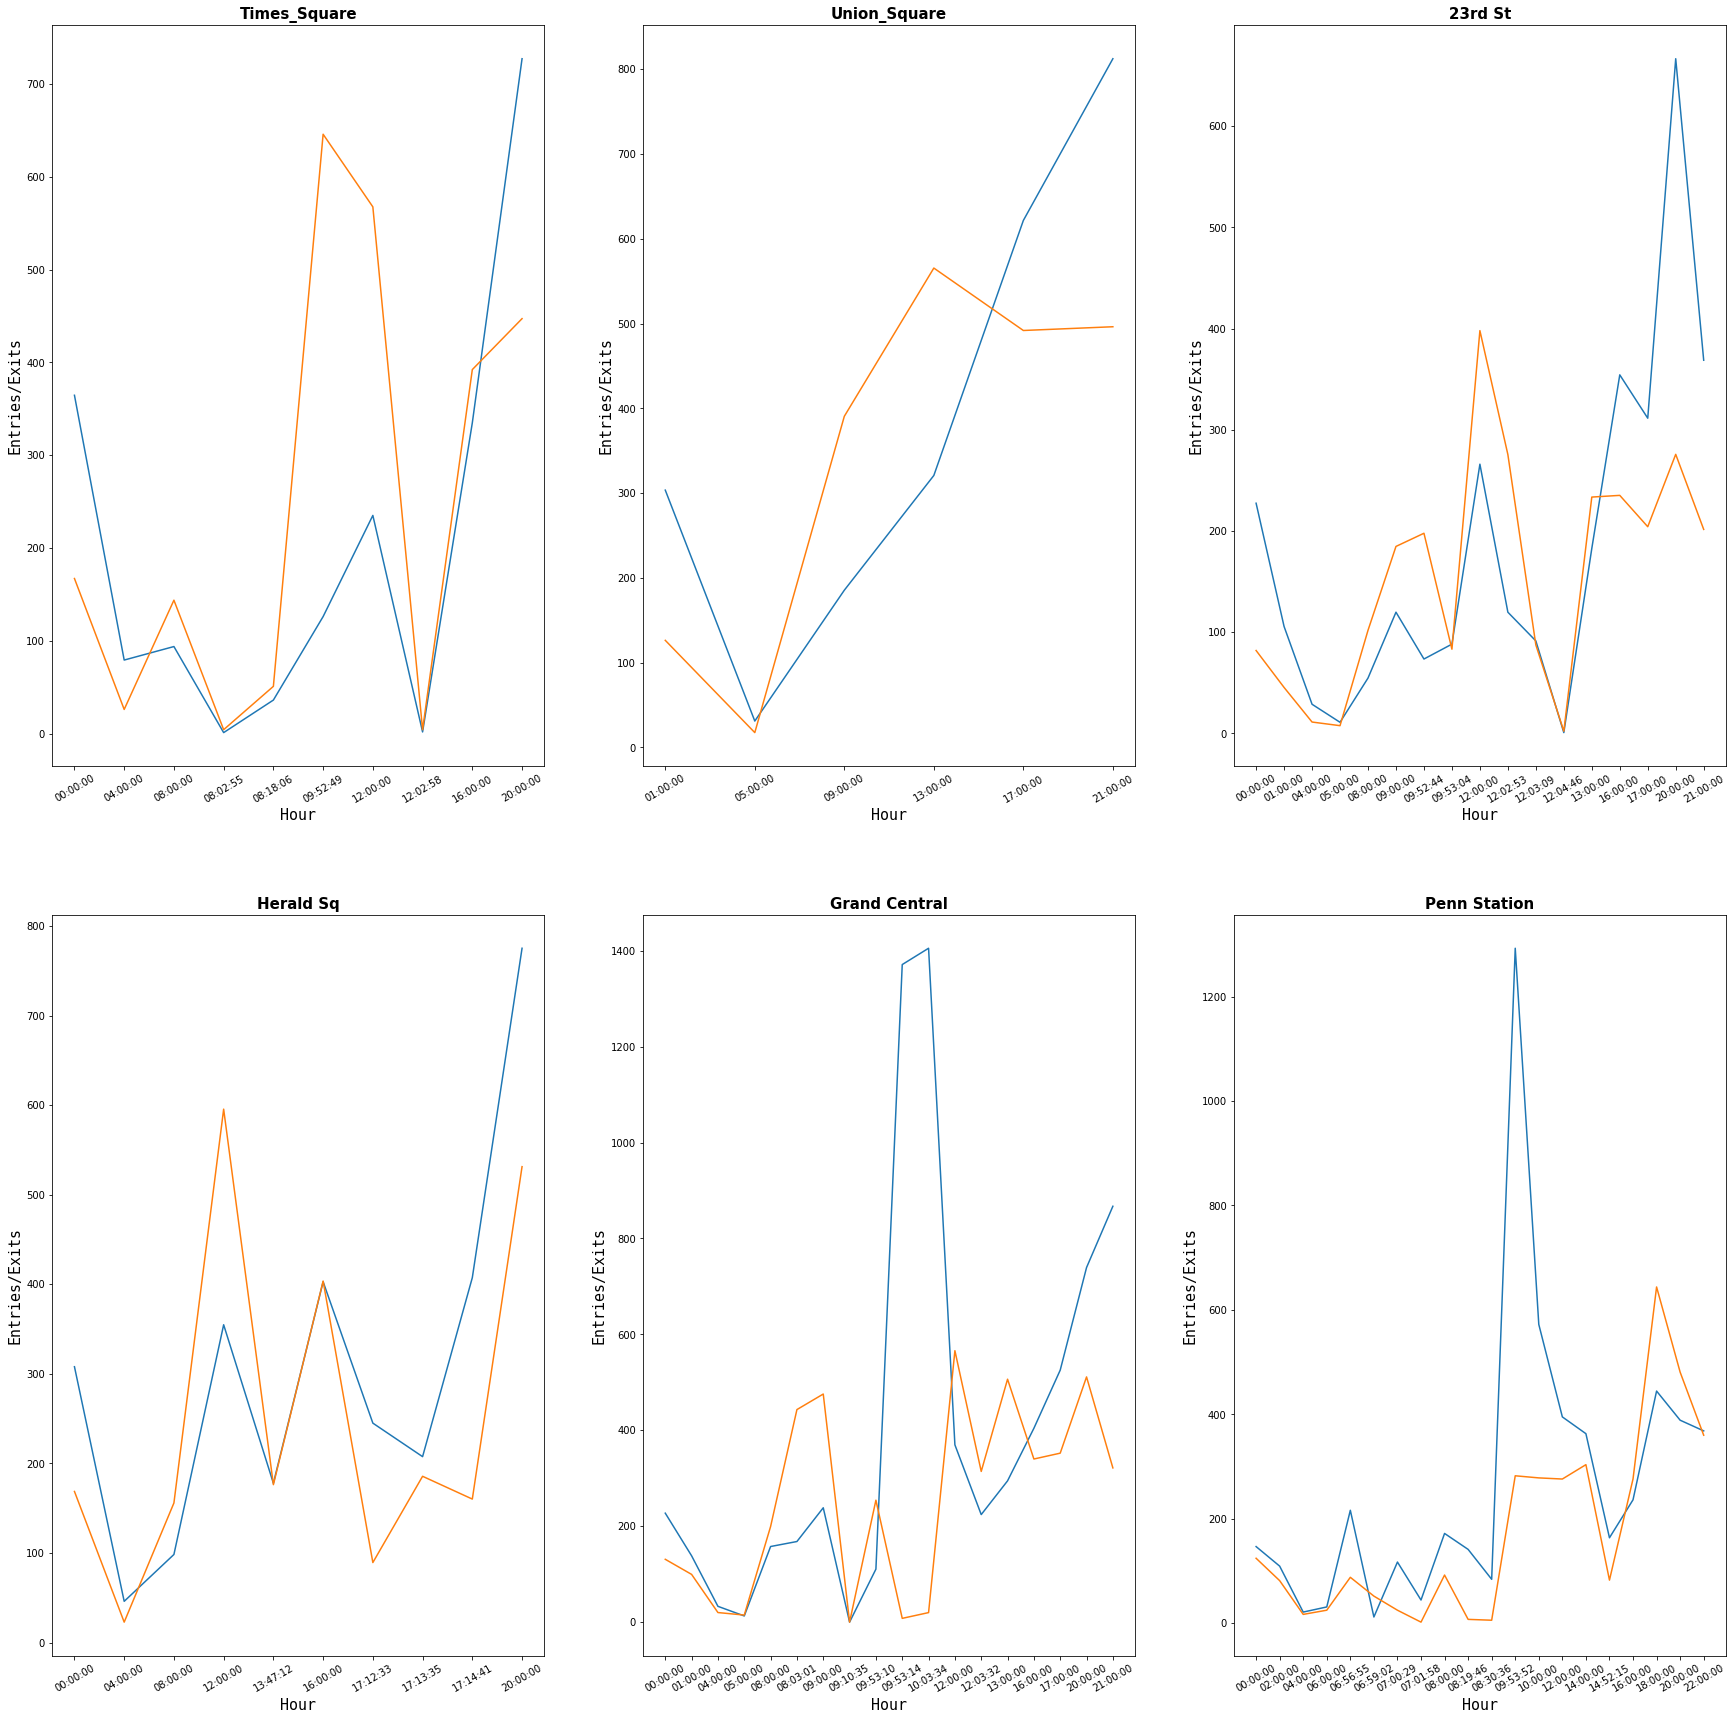

In [183]:
fig.set_figwidth(10)
fig.set_figheight(6)


plt.figure(figsize = [30, 30])

fig.suptitle('Top 6 Performing Stations',fontsize = 16)

plt.subplot(2,3,1)
plt.plot(times_hourly_df['time'],times_hourly_df['entry_increments'])
plt.plot(times_hourly_df['time'],times_hourly_df['exit_increments'])
plt.title('Times_Square', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Entries/Exits", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Hour", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)



plt.subplot(2,3,2)
plt.plot(union_hourly_df['time'],union_hourly_df['entry_increments'])
plt.plot(union_hourly_df['time'],union_hourly_df['exit_increments'])
plt.title('Union_Square', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Entries/Exits", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Hour", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)


plt.subplot(2,3,3)
plt.plot(twentythird_hourly_df['time'],twentythird_hourly_df['entry_increments'])
plt.plot(twentythird_hourly_df['time'],twentythird_hourly_df['exit_increments'])
plt.title('23rd St', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Entries/Exits", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Hour", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)



plt.subplot(2,3,4)
plt.plot(herald_hourly_df['time'],herald_hourly_df['entry_increments'])
plt.plot(herald_hourly_df['time'],herald_hourly_df['exit_increments'])
plt.title('Herald Sq', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Entries/Exits", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Hour", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)



plt.subplot(2,3,5)
plt.plot(grand_hourly_df['time'],grand_hourly_df['entry_increments'])
plt.plot(grand_hourly_df['time'],grand_hourly_df['exit_increments'])
plt.title('Grand Central', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Entries/Exits", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Hour", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)


plt.subplot(2,3,6)
plt.plot(penn_hourly_df['time'],penn_hourly_df['entry_increments'])
plt.plot(penn_hourly_df['time'],penn_hourly_df['exit_increments'])
plt.title('Penn Station', fontsize=15, weight = 'bold')
# plt.title('Entries and Exits', fontsize=10, weight = 'bold')
# x_labels = ['Saturday', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
# ticks_x = np.linspace(0, 42, 7)
# plt.xticks(ticks_x, x_labels, fontsize = '10', family = 'monospace',color='black')
plt.ylabel("Entries/Exits", fontsize = '15', family = 'monospace',color='black');
plt.xlabel("Hour", fontsize = '15', family = 'monospace',color='black')
plt.xticks(rotation=30)

plt.savefig('top_stations_by_hour.png');

In [190]:
corr = penn_hourly_df.corr()

corr.head()

,entry_increments,exit_increments
entry_increments,1.0000,0.5713
exit_increments,0.5713,1.0000
